In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc, f1_score, jaccard_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../SistersLab-Project/PCOS_data.csv")
df = data.drop(["Sl. No", "Patient File No.",  "Unnamed: 44"], axis=1)

In [3]:
df.rename(columns={'Height(Cm) ': 'Height(Cm)'}, inplace=True)
df.rename(columns={'Marraige Status (Yrs)': 'Marriage Status (Yrs)'}, inplace=True)
df.rename(columns={'Pulse rate(bpm) ': 'Pulse rate(bpm)'}, inplace=True)
df.rename(columns={'II    beta-HCG(mIU/mL)': 'II_beta_HCG(mIU/mL)'}, inplace=True)
df.rename(columns={' Age (yrs)': 'Age (yrs)'}, inplace=True)
df.rename(columns={'  I   beta-HCG(mIU/mL)': 'I_beta_HCG(mIU/mL)'}, inplace=True)
df.rename(columns={'No. of abortions': 'No_of_abortions'}, inplace=True)
df.rename(columns={'BP _Systolic (mmHg)': 'BP_Systolic(mmHg)'}, inplace=True)
df.rename(columns={'BP _Diastolic (mmHg)': 'BP_Diastolic(mmHg)'}, inplace=True)
df.rename(columns={'Waist:Hip Ratio': 'WaistHip_Ratio'}, inplace=True)

df.loc[df['II_beta_HCG(mIU/mL)'] == '1.99.', 'II_beta_HCG(mIU/mL)'] = 1.99
df.loc[df['AMH(ng/mL)'] == 'a', 'AMH(ng/mL)'] = np.nan # eksik değer
df['II_beta_HCG(mIU/mL)'] = pd.to_numeric(df['II_beta_HCG(mIU/mL)'], errors='coerce').astype('float64')
df['AMH(ng/mL)'] = pd.to_numeric(df['AMH(ng/mL)'], errors='coerce').astype('float64')
# df[df.index == 329]
#df.drop(329, inplace=True);

In [4]:
df.isnull().sum()

PCOS (Y/N)               0
Age (yrs)                0
Weight (Kg)              0
Height(Cm)               0
BMI                      0
Blood Group              0
Pulse rate(bpm)          0
RR (breaths/min)         0
Hb(g/dl)                 0
Cycle(R/I)               0
Cycle length(days)       0
Marriage Status (Yrs)    1
Pregnant(Y/N)            0
No_of_abortions          0
I_beta_HCG(mIU/mL)       0
II_beta_HCG(mIU/mL)      0
FSH(mIU/mL)              0
LH(mIU/mL)               0
FSH/LH                   0
Hip(inch)                0
Waist(inch)              0
WaistHip_Ratio           0
TSH (mIU/L)              0
AMH(ng/mL)               1
PRL(ng/mL)               0
Vit D3 (ng/mL)           0
PRG(ng/mL)               0
RBS(mg/dl)               0
Weight gain(Y/N)         0
hair growth(Y/N)         0
Skin darkening (Y/N)     0
Hair loss(Y/N)           0
Pimples(Y/N)             0
Fast food (Y/N)          1
Reg.Exercise(Y/N)        0
BP_Systolic(mmHg)        0
BP_Diastolic(mmHg)       0
F

In [5]:
df["Marriage Status (Yrs)"].fillna(df["Marriage Status (Yrs)"].median(), inplace=True)
df["AMH(ng/mL)"].fillna(df["AMH(ng/mL)"].median(), inplace=True)
df["Fast food (Y/N)"].fillna(df["Fast food (Y/N)"].mode()[0], inplace=True)

In [6]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [7]:
num_cols = ['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI',
       'Blood Group', 'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)',
        'Cycle length(days)', 'Marriage Status (Yrs)',
       'Pregnant(Y/N)', 'No_of_abortions', 'I_beta_HCG(mIU/mL)',
       'II_beta_HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH',
       'Hip(inch)', 'Waist(inch)', 'WaistHip_Ratio', 'TSH (mIU/L)',
       'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)', 'PRG(ng/mL)',
       'RBS(mg/dl)', 'BP_Systolic(mmHg)',
       'BP_Diastolic(mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)']

In [8]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.01, 0.99))

Age (yrs) False
Weight (Kg) False
Height(Cm) False
BMI False
Blood Group False
Pulse rate(bpm) True
RR (breaths/min) False
Hb(g/dl) False
Cycle length(days) False
Marriage Status (Yrs) False
Pregnant(Y/N) False
No_of_abortions False
I_beta_HCG(mIU/mL) False
II_beta_HCG(mIU/mL) True
FSH(mIU/mL) True
LH(mIU/mL) True
FSH/LH True
Hip(inch) False
Waist(inch) False
WaistHip_Ratio False
TSH (mIU/L) True
AMH(ng/mL) True
PRL(ng/mL) False
Vit D3 (ng/mL) True
PRG(ng/mL) True
RBS(mg/dl) True
BP_Systolic(mmHg) True
BP_Diastolic(mmHg) True
Follicle No. (L) False
Follicle No. (R) False
Avg. F size (L) (mm) False
Avg. F size (R) (mm) False
Endometrium (mm) False


In [9]:
replace_with_thresholds(df, "II_beta_HCG(mIU/mL)")
replace_with_thresholds(df, "FSH(mIU/mL)")
replace_with_thresholds(df, "FSH/LH")
replace_with_thresholds(df, "TSH (mIU/L)")
replace_with_thresholds(df, "PRL(ng/mL)")
replace_with_thresholds(df, "PRG(ng/mL)")

I_beta_HCG(mIU/mL) True
II_beta_HCG(mIU/mL) True

FSH(mIU/mL) True

FSH/LH True
TSH (mIU/L) True >> non pcos

PRL(ng/mL) True non pcos
PRG(ng/mL) True non pcos

BP_Systolic(mmHg) True
BP_Diastolic(mmHg) True

LH(mIU/mL) True >> pcoslu
AMH(ng/mL) True >> 66.00 pcoslu
RBS(mg/dl) True >> burada 350 değeri pcoslu biri
Vit D3 (ng/mL) True >> 6014.66 pcoslu

In [10]:
df.drop(["I_beta_HCG(mIU/mL)", "II_beta_HCG(mIU/mL)"], axis=1, inplace=True)

In [11]:
y = df[["PCOS (Y/N)"]]
X = df.drop("PCOS (Y/N)", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

In [12]:
cols = ['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'BMI', 'Blood Group',
       'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)',
       'Cycle length(days)', 'Marriage Status (Yrs)', 'Pregnant(Y/N)',
       'No_of_abortions',
       'FSH(mIU/mL)', 'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)',
       'WaistHip_Ratio', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)',
       'Vit D3 (ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)',
       'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)',
       'Pimples(Y/N)', 'Fast food (Y/N)', 'Reg.Exercise(Y/N)',
       'BP_Systolic(mmHg)', 'BP_Diastolic(mmHg)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)',
       'Endometrium (mm)']

sc = StandardScaler()
for col in cols:
    X_train[col] = sc.fit_transform(X_train[[col]])
    X_test[col] = sc.transform(X_test[[col]])

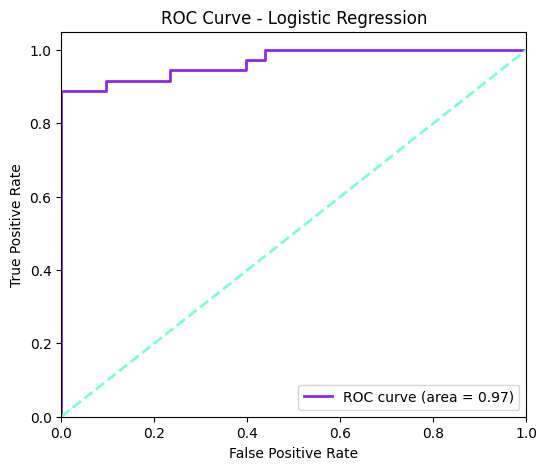

Logistic Regression classification report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        73
           1       1.00      0.83      0.91        36

    accuracy                           0.94       109
   macro avg       0.96      0.92      0.93       109
weighted avg       0.95      0.94      0.94       109



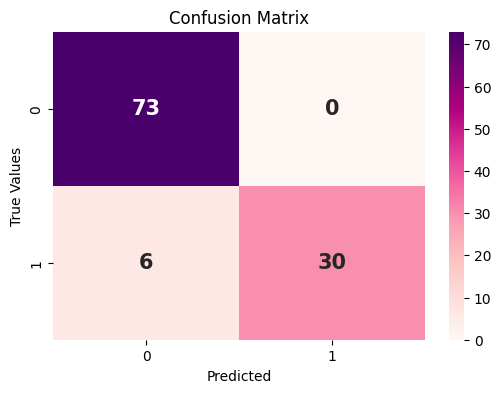

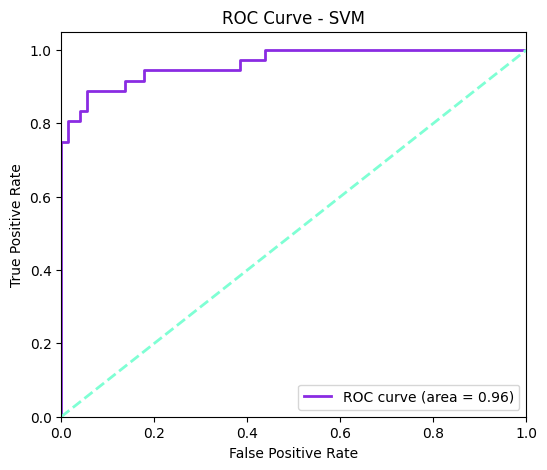

SVM classification report : 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        73
           1       1.00      0.75      0.86        36

    accuracy                           0.92       109
   macro avg       0.95      0.88      0.90       109
weighted avg       0.93      0.92      0.91       109



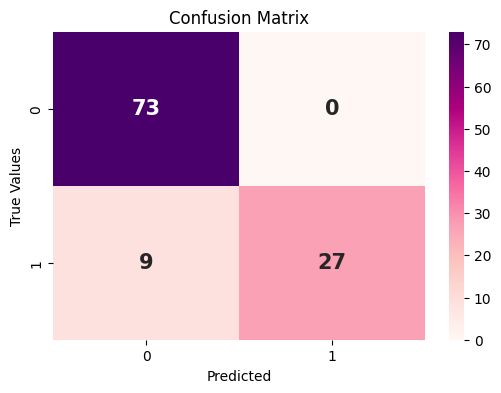

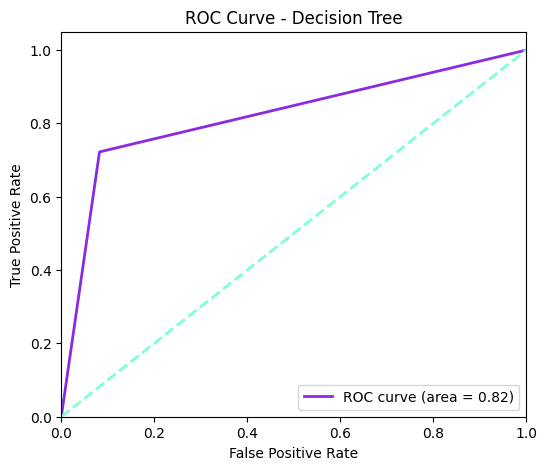

Decision Tree classification report : 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89        73
           1       0.81      0.72      0.76        36

    accuracy                           0.85       109
   macro avg       0.84      0.82      0.83       109
weighted avg       0.85      0.85      0.85       109



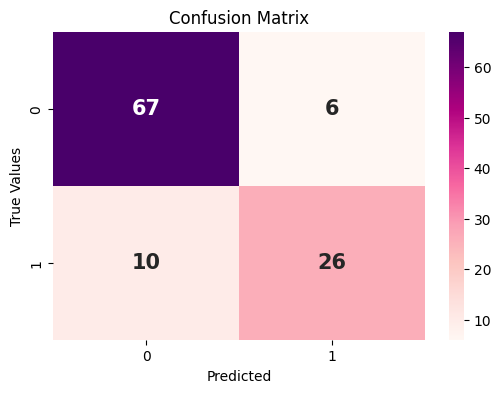

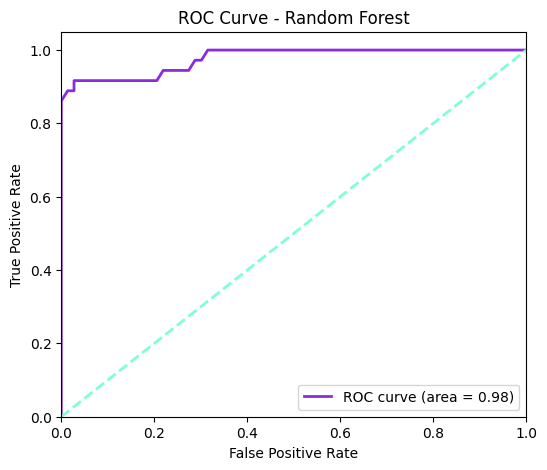

Random Forest classification report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        73
           1       1.00      0.83      0.91        36

    accuracy                           0.94       109
   macro avg       0.96      0.92      0.93       109
weighted avg       0.95      0.94      0.94       109



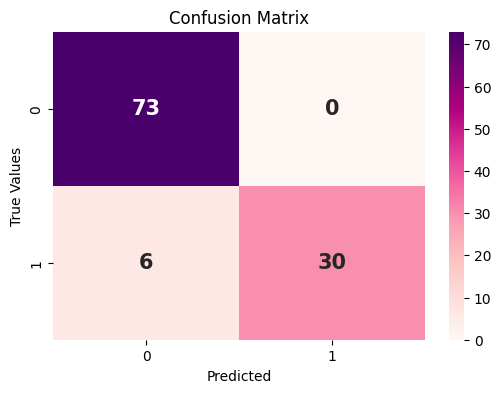

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 141, number of negative: 291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 432, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326389 -> initscore=-0.724563
[LightGBM] [Info] Start training from score -0.724563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

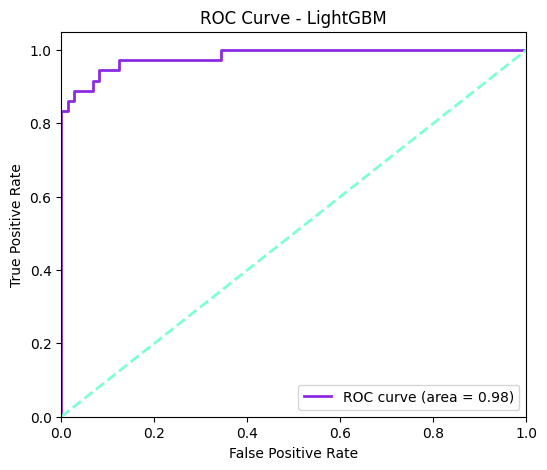

LightGBM classification report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        73
           1       1.00      0.83      0.91        36

    accuracy                           0.94       109
   macro avg       0.96      0.92      0.93       109
weighted avg       0.95      0.94      0.94       109



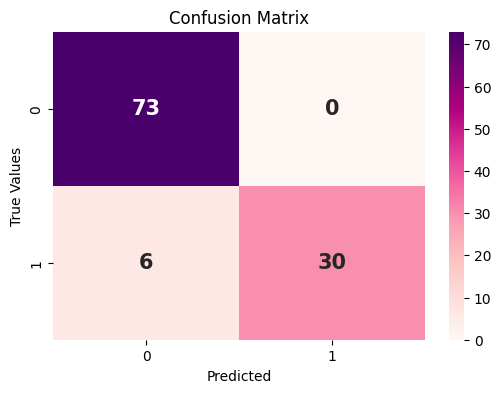

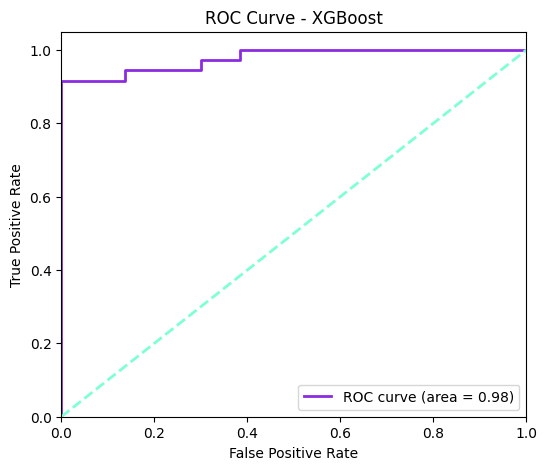

XGBoost classification report : 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        73
           1       1.00      0.92      0.96        36

    accuracy                           0.97       109
   macro avg       0.98      0.96      0.97       109
weighted avg       0.97      0.97      0.97       109



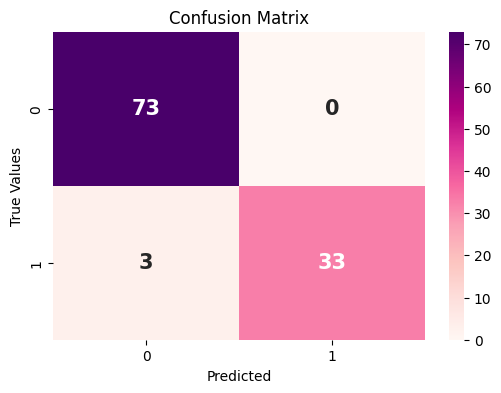

In [64]:
models = {'Logistic Regression': LogisticRegression(random_state=42),
          'SVM': SVC(random_state=42, probability=True),
          'Decision Tree': DecisionTreeClassifier(random_state=42),
          'Random Forest': RandomForestClassifier(random_state=42),
          'LightGBM': LGBMClassifier(random_state=42),
          'XGBoost': XGBClassifier(random_state=42)}

columns = ['Model', 'Test Accuracy', 'F1-Score', 'Jaccard Score', 'AUC Score', 'Precision', 'Recall']
result_df = pd.DataFrame(columns=columns)
results=[]

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, result_df):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    jaccard = jaccard_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test,  model.predict_proba(X_test)[:,1])
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    results.append([test_acc, precision, recall, f1, auc_score])

    # ROC Curve çizimi
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blueviolet', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='aquamarine', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix ve Classification Report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print(f"{model_name} classification report : \n {cr}" )

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", xticklabels=model.classes_, yticklabels=model.classes_, annot_kws={'size': 15, 'fontweight': 'semibold'})
    plt.xlabel('Predicted')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    result_df = result_df._append({'Model': model_name,
                                   'Test Accuracy': test_acc,
                                   'Jaccard Score': jaccard,
                                   'AUC Score': auc_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1-Score': f1}, ignore_index=True)

    return result_df

for model_name, model in models.items():
    result_df = evaluate_model(model, X_train, y_train, X_test, y_test, model_name, result_df)

In [65]:
result_df

Model  Test Accuracy  F1-Score  Jaccard Score  AUC Score  \
0  Logistic Regression       0.944954  0.943538       0.833333   0.967656   
1                  SVM       0.917431  0.913931       0.750000   0.963470   
2        Decision Tree       0.853211  0.850851       0.619048   0.820015   
3        Random Forest       0.944954  0.943538       0.833333   0.976788   
4             LightGBM       0.944954  0.943538       0.833333   0.981735   
5              XGBoost       0.972477  0.972156       0.916667   0.977169   

   Precision    Recall  
0   0.949135  0.944954  
1   0.926494  0.917431  
2   0.851096  0.853211  
3   0.949135  0.944954  
4   0.949135  0.944954  
5   0.973563  0.972477

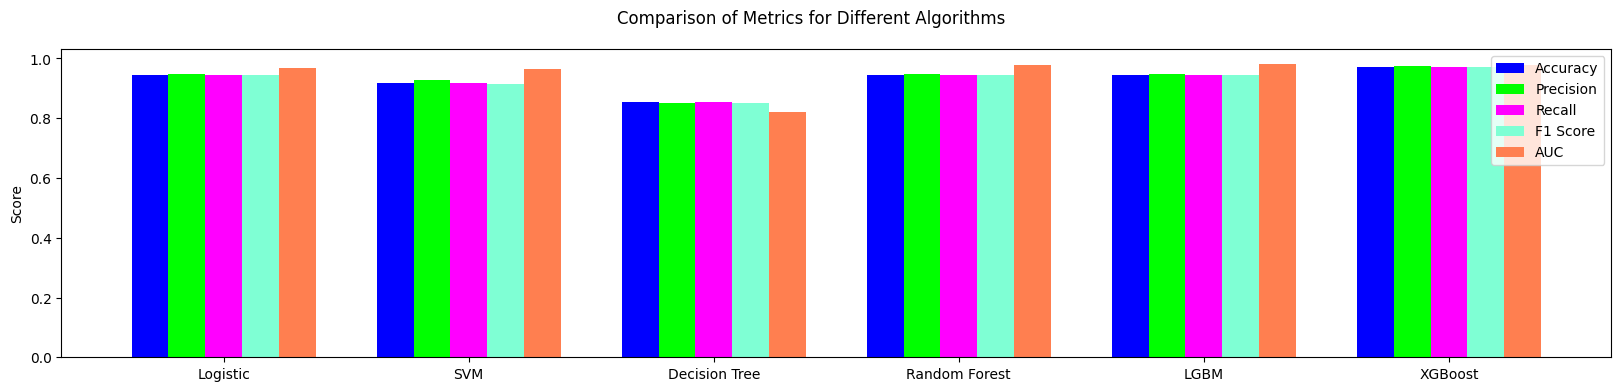

In [66]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
names = ['Logistic', 'SVM', 'Decision Tree', 'Random Forest', 'LGBM', 'XGBoost']

# Transpose the results for correct plotting
new_results = list(map(list, zip(*results)))

fig, ax = plt.subplots(figsize=(20, 4))
bar_width = 0.15
bar_positions = np.arange(len(names))
colors = ['blue', 'lime', 'fuchsia', 'aquamarine', 'coral']

for i, metric in enumerate(metrics):
    ax.bar(bar_positions + i * bar_width, new_results[i], width=bar_width, label=metric, color=colors[i])

ax.set_xticks(bar_positions + (len(metrics) - 1) * bar_width / 2)
ax.set_xticklabels(names)
ax.set_ylabel('Score')
ax.legend()
fig.suptitle('Comparison of Metrics for Different Algorithms')
plt.show()

---

In [34]:
parametre_grids = {'Logistic Regression': {'C': [0.001, 0.05, 0.01, 0.1, 1], 'max_iter': [100, 200, 300, 500], 'random_state': [100, 42, 45]},
                   'SVM': {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'random_state': [100, 42, 45]},
                   'Decision Tree': {'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10], 'random_state': [100, 42, 45]},
                   'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'random_state': [100, 42, 45]},
                   'LightGBM': {'num_leaves': [31, 50, 100], 'learning_rate': [0.01, 0.05, 0.1],"n_estimators": [300, 500], 'random_state': [100, 42, 45]},
                   'XGBoost': {'n_estimators': [200, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1],  "max_depth": [2, 3, 4], 'random_state': [100, 42, 45]}}

models = {'Logistic Regression': LogisticRegression(random_state=42),
          'SVM': SVC(random_state=42, probability=True),
          'Decision Tree': DecisionTreeClassifier(random_state=42),
          'Random Forest': RandomForestClassifier(random_state=42),
          'LightGBM': LGBMClassifier(random_state=42),
          'XGBoost': XGBClassifier(random_state=42)}

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Logistic Regression Best Parameters: 
 {'C': 0.05, 'max_iter': 100, 'random_state': 100}


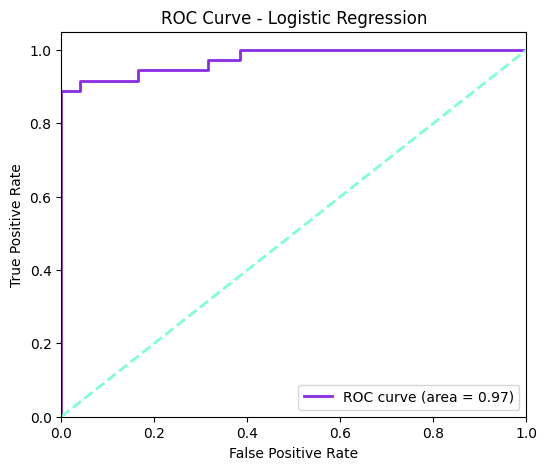

Logistic Regression classification report : 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        73
           1       1.00      0.81      0.89        36

    accuracy                           0.94       109
   macro avg       0.96      0.90      0.92       109
weighted avg       0.94      0.94      0.93       109



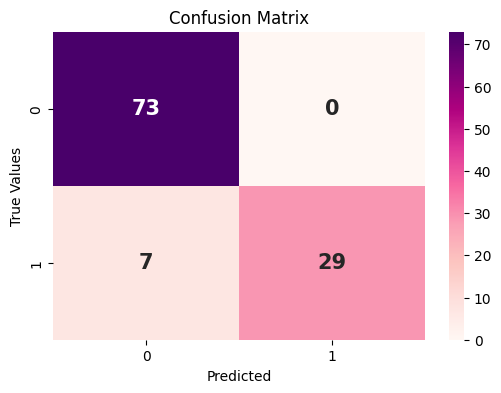

Fitting 3 folds for each of 60 candidates, totalling 180 fits
SVM Best Parameters: 
 {'C': 10, 'gamma': 0.001, 'random_state': 100}


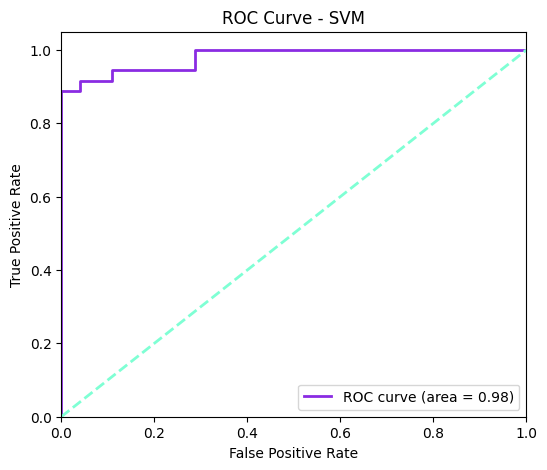

SVM classification report : 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        73
           1       1.00      0.81      0.89        36

    accuracy                           0.94       109
   macro avg       0.96      0.90      0.92       109
weighted avg       0.94      0.94      0.93       109



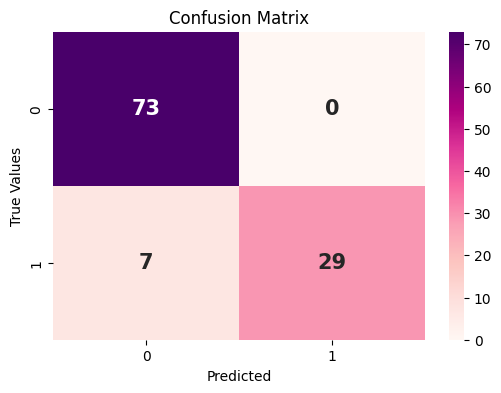

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Decision Tree Best Parameters: 
 {'max_depth': 10, 'min_samples_split': 2, 'random_state': 42}


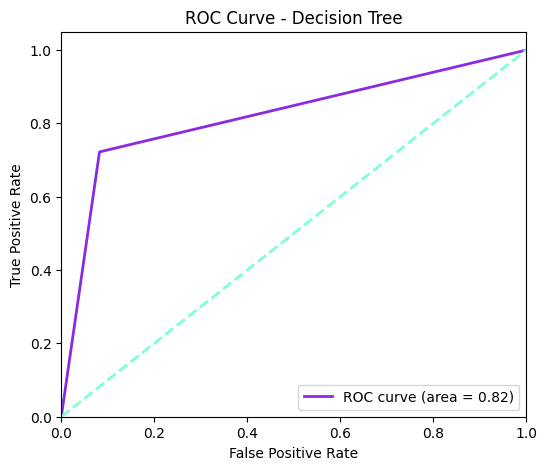

Decision Tree classification report : 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89        73
           1       0.81      0.72      0.76        36

    accuracy                           0.85       109
   macro avg       0.84      0.82      0.83       109
weighted avg       0.85      0.85      0.85       109



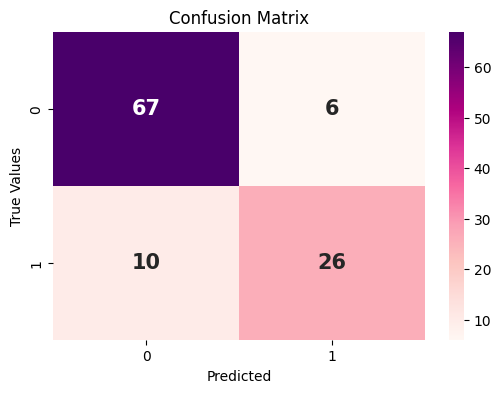

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Best Parameters: 
 {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 45}


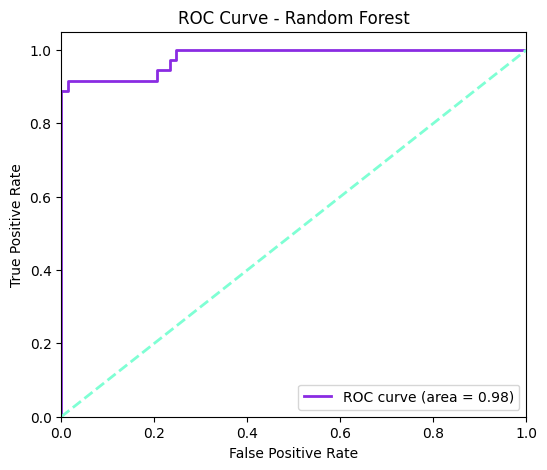

Random Forest classification report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97        73
           1       0.97      0.89      0.93        36

    accuracy                           0.95       109
   macro avg       0.96      0.94      0.95       109
weighted avg       0.95      0.95      0.95       109



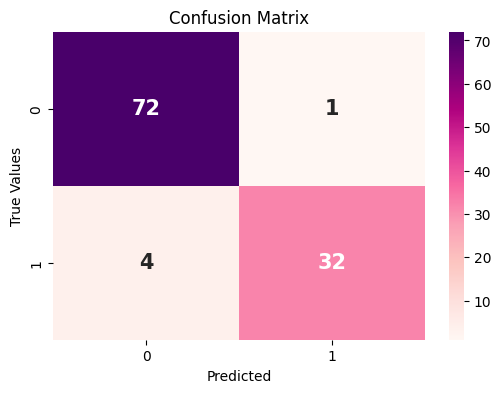

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94, number of negative: 194
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 288, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326389 -> initscore=-0.724563
[LightGBM] [Info] Start training from score -0.724563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

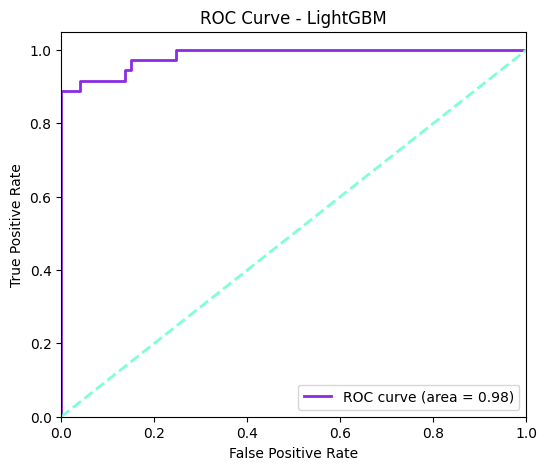

LightGBM classification report : 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        73
           1       1.00      0.81      0.89        36

    accuracy                           0.94       109
   macro avg       0.96      0.90      0.92       109
weighted avg       0.94      0.94      0.93       109



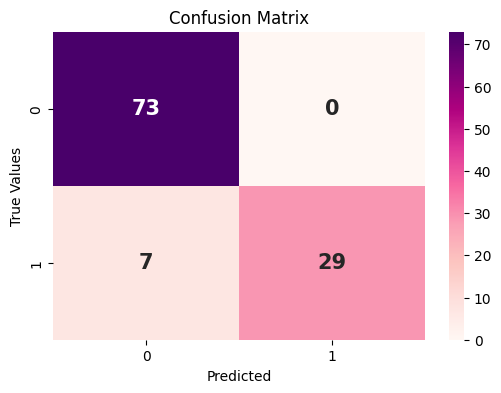

Fitting 3 folds for each of 81 candidates, totalling 243 fits
XGBoost Best Parameters: 
 {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'random_state': 100}


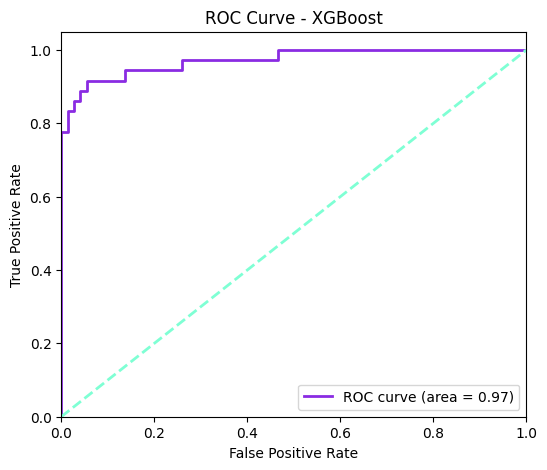

XGBoost classification report : 
               precision    recall  f1-score   support

           0       0.92      0.97      0.95        73
           1       0.94      0.83      0.88        36

    accuracy                           0.93       109
   macro avg       0.93      0.90      0.91       109
weighted avg       0.93      0.93      0.93       109



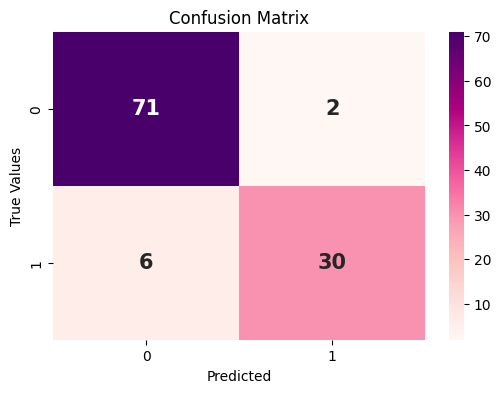

In [35]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

columns = ['Model', 'Test Accuracy', 'F1-Score', 'Jaccard Score', 'AUC Score', 'Precision', 'Recall']
results_tuned_df = pd.DataFrame(columns=columns)
results_tuned = []

for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=parametre_grids[model_name], scoring='accuracy', cv=cv, verbose=1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"{model_name} Best Parameters: \n {best_params}")
    best_model = grid_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    jaccard = jaccard_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    results_tuned.append([test_acc, precision, recall, f1, auc_score])

    # ROC Curve çizimi
    fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blueviolet', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='aquamarine', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)

    print(f"{model_name} classification report : \n {cr}" )
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", annot_kws={'size': 15, 'fontweight': 'semibold'})
    plt.xlabel('Predicted')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    results_tuned_df = results_tuned_df._append({
        'Model': model_name,
        'Test Accuracy': test_acc,
        'F1-Score': f1,
        'Jaccard Score': jaccard,
        'AUC Score': auc_score,
        'Precision': precision,
        'Recall': recall
    }, ignore_index=True)

In [36]:
results_tuned_df

Model  Test Accuracy  F1-Score  Jaccard Score  AUC Score  \
0  Logistic Regression       0.935780  0.933791       0.805556   0.974886   
1                  SVM       0.935780  0.933791       0.805556   0.979833   
2        Decision Tree       0.853211  0.850851       0.619048   0.820015   
3        Random Forest       0.954128  0.953593       0.864865   0.980594   
4             LightGBM       0.935780  0.933791       0.805556   0.984018   
5              XGBoost       0.926606  0.925425       0.789474   0.971842   

   Precision    Recall  
0   0.941399  0.935780  
1   0.941399  0.935780  
2   0.851096  0.853211  
3   0.954743  0.954128  
4   0.941399  0.935780  
5   0.927171  0.926606

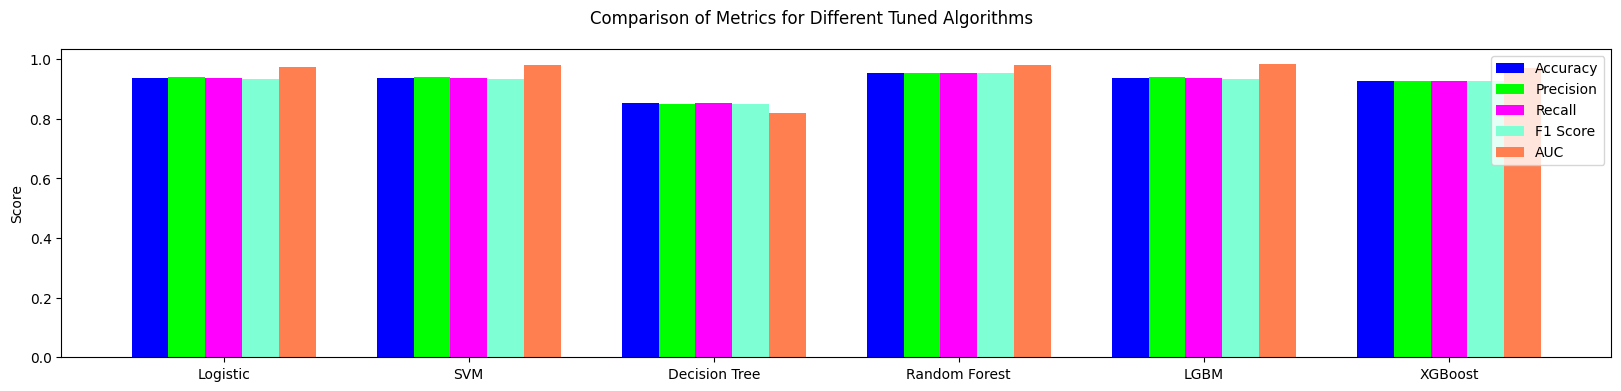

In [37]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
names = ['Logistic', 'SVM', 'Decision Tree', 'Random Forest', 'LGBM', 'XGBoost']

# Transpose the results for correct plotting
new_results = list(map(list, zip(*results_tuned)))

fig, ax = plt.subplots(figsize=(20, 4))
bar_width = 0.15
bar_positions = np.arange(len(names))
colors = ['blue', 'lime', 'fuchsia', 'aquamarine', 'coral']

for i, metric in enumerate(metrics):
    ax.bar(bar_positions + i * bar_width, new_results[i], width=bar_width, label=metric, color=colors[i])

ax.set_xticks(bar_positions + (len(metrics) - 1) * bar_width / 2)
ax.set_xticklabels(names)
ax.set_ylabel('Score')
ax.legend()
fig.suptitle('Comparison of Metrics for Different Tuned Algorithms')
plt.show()

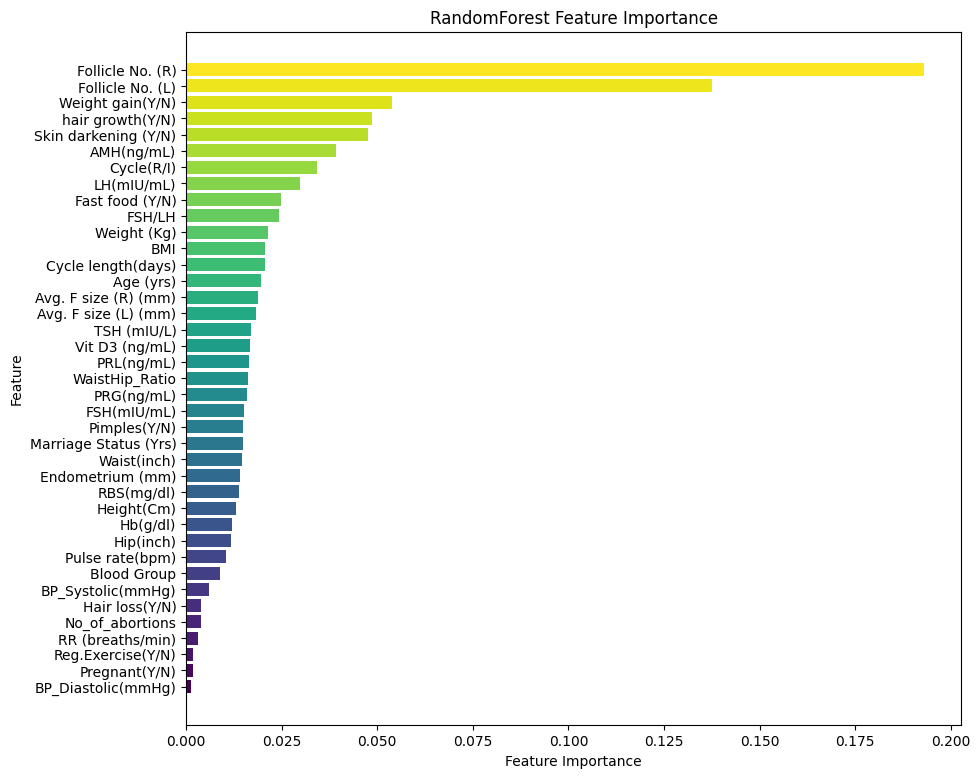

In [20]:
rf_model = RandomForestClassifier(max_depth = 10, min_samples_split = 5, n_estimators = 100, random_state = 45)
rf_model.fit(X_train, y_train)
feature_importances = rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)

colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importances)))

plt.figure(figsize=(10, 9))
bars = plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], color=colors)
plt.yticks(range(len(feature_importances)), np.array(X_train.columns)[sorted_indices])

for bar, label in zip(bars, np.array(X_train.columns)[sorted_indices]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,s=None, ha='left', va='center')

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('RandomForest Feature Importance')
plt.show()